<a href="https://colab.research.google.com/github/JH-KIM-82/Final-Team1/blob/main/%EA%B2%80%EC%A6%9D_%ED%9D%A5%ED%96%89%EC%9A%94%EC%86%8C_%EA%B0%80%EC%84%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

# 초기 버전

데이터셋을 성공적으로 불러왔습니다.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188273 entries, 0 to 188272
Data columns (total 52 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ﻿"﻿""recommendationid"""        188273 non-null  int64  
 1   appid                           188273 non-null  int64  
 2   game                            188260 non-null  object 
 3   author_steamid                  188273 non-null  int64  
 4   author_num_games_owned          188273 non-null  int64  
 5   author_num_reviews              188273 non-null  int64  
 6   author_playtime_forever         188273 non-null  int64  
 7   author_playtime_last_two_weeks  188273 non-null  int64  
 8   author_playtime_at_review       188273 non-null  int64  
 9   author_last_played              188273 non-null  object 
 10  user_groupby_owner              188273 non-null  object 
 11  user_groupby_playtime           188273 non-null  object 
 

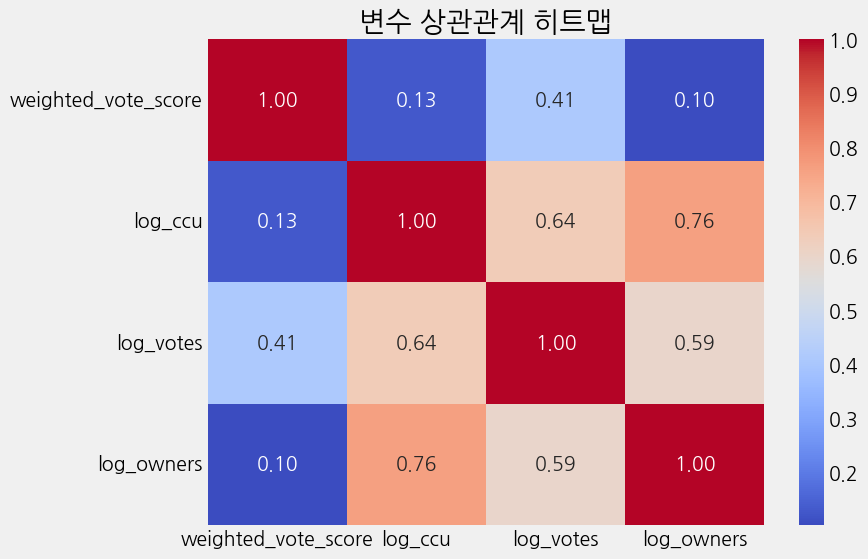

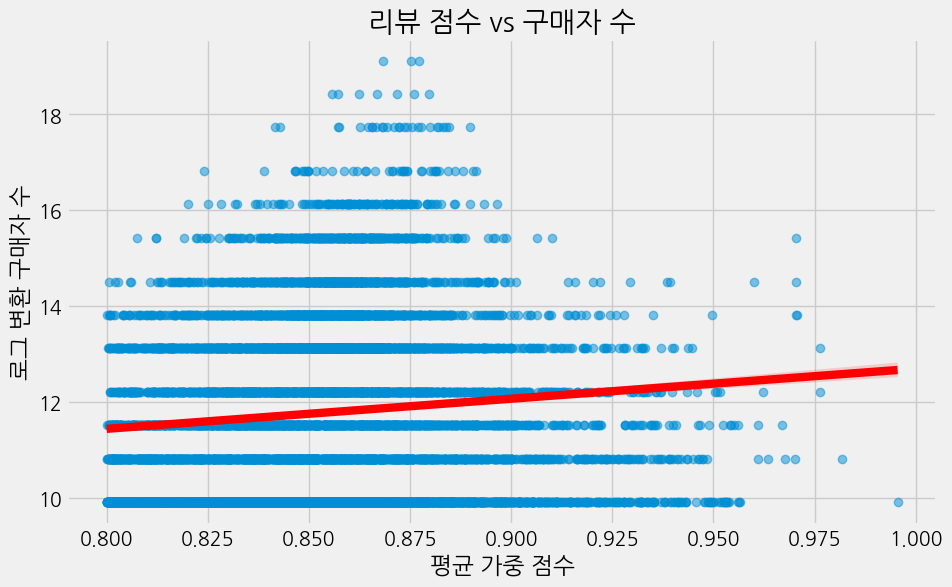

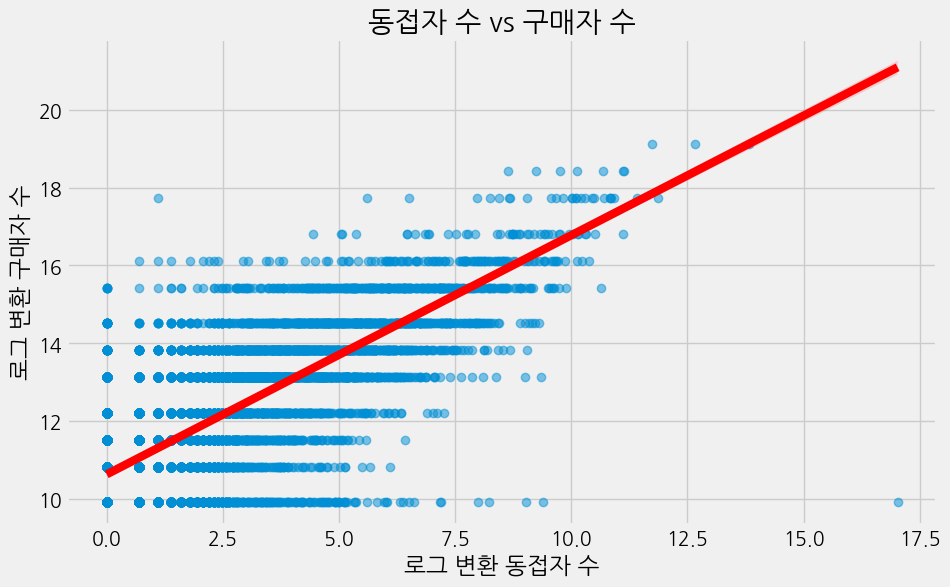

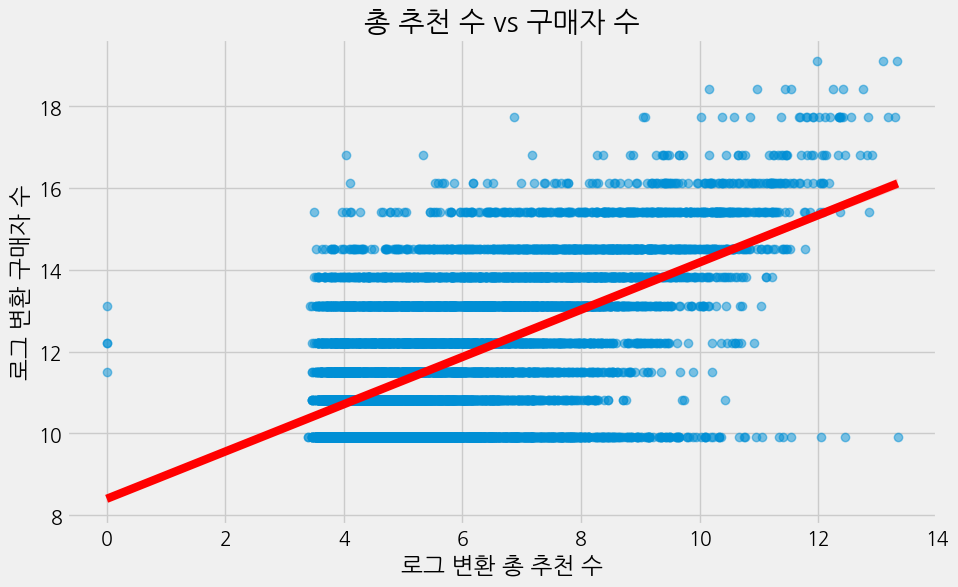


===== 다변량 회귀 분석 결과 =====
                            OLS Regression Results                            
Dep. Variable:             log_owners   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     5808.
Date:                Tue, 30 Sep 2025   Prob (F-statistic):               0.00
Time:                        05:52:37   Log-Likelihood:                -17622.
No. Observations:               11566   AIC:                         3.525e+04
Df Residuals:                   11562   BIC:                         3.528e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const   

In [ ]:
# =======================================================
# 게임 리뷰 데이터 분석 (보강, Colab용)
# =======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)
plt.style.use('fivethirtyeight')

# =======================================================
# 0. 데이터 불러오기
# =======================================================
try:
    df = pd.read_csv('/content/S-team_250930-final.csv')
    print("데이터셋을 성공적으로 불러왔습니다.")
    df.info()
except FileNotFoundError:
    print("오류: 'weighted_score_above_08_250925.csv' 파일을 찾을 수 없습니다.")
    exit()

# =======================================================
# 1. 데이터 전처리
# =======================================================
# owners_max 숫자 변환
df['owners_max'] = df['owners_max'].astype(str).str.replace(',', '').astype(float)

# 게임별 집계
game_stats = df.groupby('appid').agg(
    weighted_vote_score=('weighted_vote_score', 'mean'),
    votes_up=('votes_up', 'sum'),
    owners_max=('owners_max', 'mean'),
    ccu=('ccu', 'mean'),
    game=('game', 'first')
).reset_index()

# 결측치 제거
game_stats.dropna(subset=['weighted_vote_score', 'owners_max', 'ccu'], inplace=True)
print("\n정제된 데이터의 첫 5개 행:")
print(game_stats.head())

# =======================================================
# 2. 로그 변환 (극단값 완화)
# =======================================================
game_stats['log_owners'] = np.log1p(game_stats['owners_max'])
game_stats['log_ccu'] = np.log1p(game_stats['ccu'])
game_stats['log_votes'] = np.log1p(game_stats['votes_up'])

# =======================================================
# 3. 상관계수 히트맵
# =======================================================
plt.figure(figsize=(8,6))
corr = game_stats[['weighted_vote_score','log_ccu','log_votes','log_owners']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('변수 상관관계 히트맵')
plt.show()

# =======================================================
# 4. 산점도 + 회귀선 시각화
# =======================================================
def scatter_with_reg(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(10,6))
    sns.regplot(x=x, y=y, data=game_stats, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

scatter_with_reg('weighted_vote_score','log_owners',
                 '평균 가중 점수', '로그 변환 구매자 수',
                 '리뷰 점수 vs 구매자 수')

scatter_with_reg('log_ccu','log_owners',
                 '로그 변환 동접자 수', '로그 변환 구매자 수',
                 '동접자 수 vs 구매자 수')

scatter_with_reg('log_votes','log_owners',
                 '로그 변환 총 추천 수', '로그 변환 구매자 수',
                 '총 추천 수 vs 구매자 수')

# =======================================================
# 5. 다변량 회귀 분석
# =======================================================
X = game_stats[['weighted_vote_score','log_ccu','log_votes']]
y = game_stats['log_owners']
X = sm.add_constant(X)  # 상수항 추가
model = sm.OLS(y, X).fit()
print("\n===== 다변량 회귀 분석 결과 =====")
print(model.summary())


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)
plt.style.use('fivethirtyeight')

# =======================================================
# 0. 데이터 불러오기
# =======================================================
try:
    df = pd.read_csv('/content/S-team_250930-final.csv')
    print("데이터셋을 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print("오류: 'weighted_score_above_08_250925.csv' 파일을 찾을 수 없습니다.")
    exit()

# =======================================================
# 1. 데이터 전처리
# =======================================================
df['owners_max'] = df['owners_max'].astype(str).str.replace(',', '').astype(float)
game_stats = df.groupby('appid').agg(
    weighted_vote_score=('weighted_vote_score', 'mean'),
    votes_up=('votes_up', 'sum'),
    owners_max=('owners_max', 'mean'),
    ccu=('ccu', 'mean'),
    game=('game', 'first')
).reset_index()

game_stats.dropna(subset=['weighted_vote_score', 'owners_max', 'ccu'], inplace=True)

# 로그 변환
game_stats['log_owners'] = np.log1p(game_stats['owners_max'])
game_stats['log_ccu'] = np.log1p(game_stats['ccu'])
game_stats['log_votes'] = np.log1p(game_stats['votes_up'])

# =======================================================
# 2. 머신러닝 모델 구축
# =======================================================
# 예측에 사용할 특성(Features)과 목표 변수(Target) 설정
X = game_stats[['weighted_vote_score', 'log_ccu', 'log_votes']]
y = game_stats['log_owners']

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n훈련 데이터셋 크기: {len(X_train)}개")
print(f"테스트 데이터셋 크기: {len(X_test)}개")

# 여러 모델 정의
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = pd.DataFrame(columns=['Model', 'R-squared', 'MSE'])

print("\n===== 여러 모델 훈련 및 평가 =====")
for name, model in models.items():
    # 모델 훈련
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # 결과 저장
    results = pd.concat([results, pd.DataFrame([{'Model': name, 'R-squared': r2, 'MSE': mse}])], ignore_index=True)

print("\n===== 모델 성능 비교 =====")
print(results.sort_values(by='R-squared', ascending=False))


데이터셋을 성공적으로 불러왔습니다.

훈련 데이터셋 크기: 9252개
테스트 데이터셋 크기: 2314개

===== 여러 모델 훈련 및 평가 =====


/tmp/ipython-input-1422595045.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': name, 'R-squared': r2, 'MSE': mse}])], ignore_index=True)



===== 모델 성능 비교 =====
                     Model  R-squared       MSE
1         Ridge Regression   0.618489  1.199626
0        Linear Regression   0.618447  1.199757
2  Random Forest Regressor   0.589336  1.291295


In [ ]:
# =======================================================
# 3. 새로운 게임의 흥행 예측
# =======================================================
print("\n===== 새로운 게임의 잠재적 흥행 예측 =====")
# 가장 성능이 좋았던 Ridge 모델 선택
best_model = models["Ridge Regression"]

# 예측할 새로운 게임의 데이터 생성
new_game_data = pd.DataFrame([{
    'weighted_vote_score': 0.9,
    'log_ccu': np.log1p(5000),
    'log_votes': np.log1p(1000)
}])

# 예측 실행
predicted_log_owners = best_model.predict(new_game_data)

# 로그 변환을 되돌려 실제 구매자 수 예측
predicted_owners = np.expm1(predicted_log_owners)

print(f"새로운 게임의 예상 구매자 수 (로그 변환): {predicted_log_owners[0]:.2f}")
print(f"새로운 게임의 예상 구매자 수 (실제 값): {int(predicted_owners[0]):,}명")


===== 새로운 게임의 잠재적 흥행 예측 =====
새로운 게임의 예상 구매자 수 (로그 변환): 15.12
새로운 게임의 예상 구매자 수 (실제 값): 3,702,056명


In [ ]:
# =======================================================
# 4. 목표 구매자 수를 위한 지표 역산정 시뮬레이션
# =======================================================
print("\n===== 목표 구매자 수(1000만 명) 달성을 위한 시나리오 =====")
# 목표 구매자 수 설정
target_owners = 10_000_000

# 목표치를 로그 변환
target_log_owners = np.log1p(target_owners)
print(f"목표 로그 구매자 수: {target_log_owners:.2f}")

# Ridge 모델의 계수와 절편 가져오기
intercept = best_model.intercept_
coef_score = best_model.coef_[0]
coef_ccu = best_model.coef_[1]
coef_votes = best_model.coef_[2]

# 목표 구매자 수를 달성하기 위한 log_ccu 역산정 (다른 변수들은 가정)
# 가정 1: 리뷰 점수 (weighted_vote_score) = 0.85
# 가정 2: 총 추천 수 (log_votes) = np.log1p(5000)
assumed_score = 0.85
assumed_log_votes = np.log1p(5000)

# log_ccu = (target_log_owners - intercept - (coef_score * assumed_score) - (coef_votes * assumed_log_votes)) / coef_ccu
required_log_ccu = (target_log_owners - intercept - (coef_score * assumed_score) - (coef_votes * assumed_log_votes)) / coef_ccu
required_ccu = np.expm1(required_log_ccu)

print(f"가정: 리뷰 점수 {assumed_score}, 총 추천 수 5,000개")
print(f"목표(1000만 명) 달성에 필요한 예상 동시 접속자 수: {int(required_ccu):,}명")



===== 목표 구매자 수(1000만 명) 달성을 위한 시나리오 =====
목표 로그 구매자 수: 16.12
가정: 리뷰 점수 0.85, 총 추천 수 5,000개
목표(1000만 명) 달성에 필요한 예상 동시 접속자 수: 12,327명


           Model        R2       MSE
2        XGBoost  0.619635  1.196023
0          Ridge  0.618489  1.199626
1  Random Forest  0.589336  1.291295


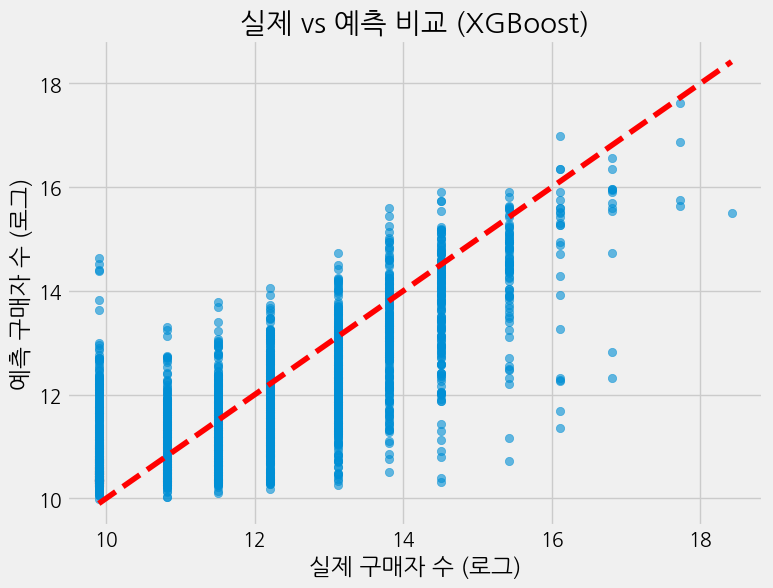

   weighted_vote_score   log_ccu  log_votes  예상 구매자 수
0                  0.9  8.517393   8.517393   1378848
1                  0.8  8.987322   9.210440   1529413


In [ ]:
# =======================================================
# 추가 보강 코드 예시
# =======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# =======================================================
# 1. 데이터 불러오기 및 전처리 (이전 코드와 동일)
# =======================================================
df = pd.read_csv('/content/S-team_250930-final.csv')
df['owners_max'] = df['owners_max'].astype(str).str.replace(',', '').astype(float)

game_stats = df.groupby('appid').agg(
    weighted_vote_score=('weighted_vote_score', 'mean'),
    votes_up=('votes_up', 'sum'),
    owners_max=('owners_max', 'mean'),
    ccu=('ccu', 'mean'),
    game=('game', 'first')
).reset_index()

game_stats.dropna(subset=['weighted_vote_score', 'owners_max', 'ccu'], inplace=True)

# 로그 변환
game_stats['log_owners'] = np.log1p(game_stats['owners_max'])
game_stats['log_ccu'] = np.log1p(game_stats['ccu'])
game_stats['log_votes'] = np.log1p(game_stats['votes_up'])

# =======================================================
# 2. 모델 비교 (Ridge, RandomForest, XGBoost)
# =======================================================
X = game_stats[['weighted_vote_score', 'log_ccu', 'log_votes']]
y = game_stats['log_owners']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Ridge": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append({"Model": name, "R2": r2, "MSE": mse})

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print(results_df)

# =======================================================
# 3. 예측값 vs 실제값 시각화 (모델 성능 확인)
# =======================================================
best_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("실제 구매자 수 (로그)")
plt.ylabel("예측 구매자 수 (로그)")
plt.title("실제 vs 예측 비교 (XGBoost)")
plt.show()

# =======================================================
# 4. 시뮬레이션 예시 (조건 변화 감도분석)
# =======================================================
scenarios = pd.DataFrame([
    {"weighted_vote_score": 0.9, "log_ccu": np.log1p(5000), "log_votes": np.log1p(5000)},
    {"weighted_vote_score": 0.8, "log_ccu": np.log1p(8000), "log_votes": np.log1p(10000)},
])

predicted_log_owners = best_model.predict(scenarios)
predicted_owners = np.expm1(predicted_log_owners)

scenarios["예상 구매자 수"] = predicted_owners.astype(int)
print(scenarios)




---



# 개선 버전

데이터 로드: /content/S-team_250930-final.csv


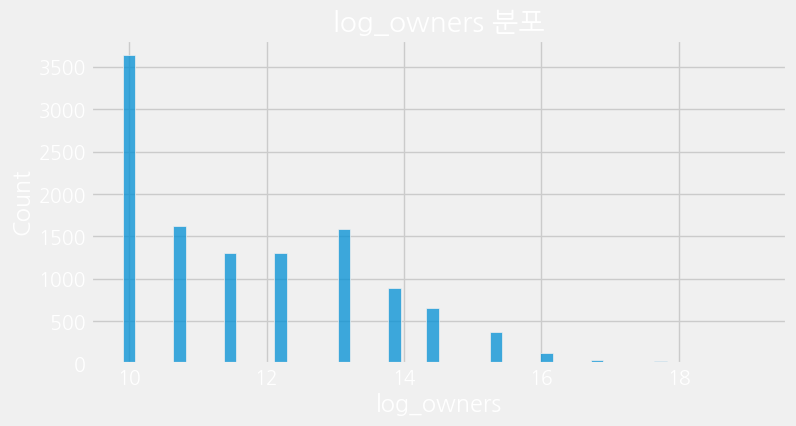

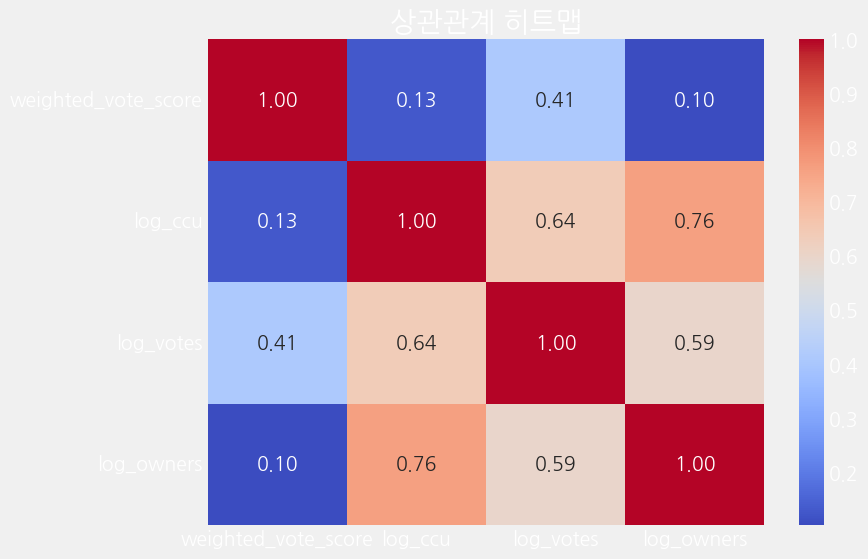

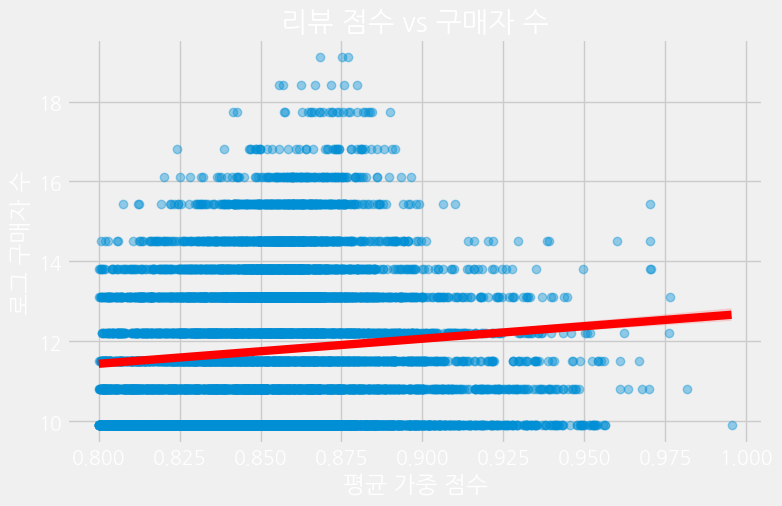

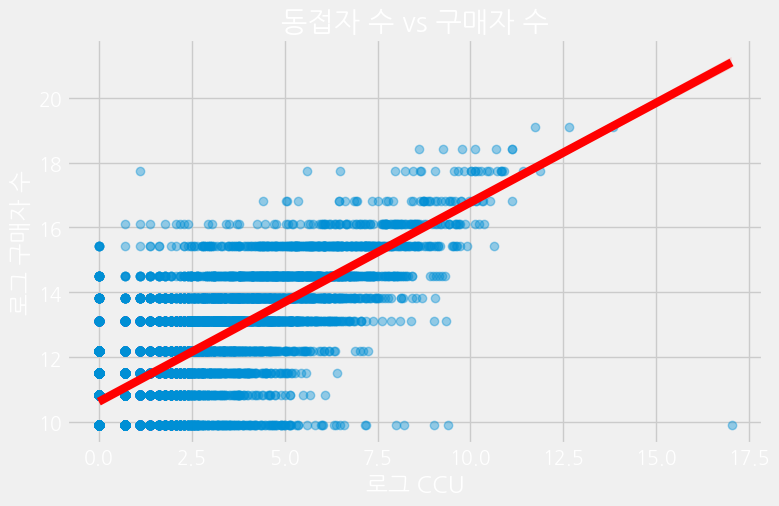

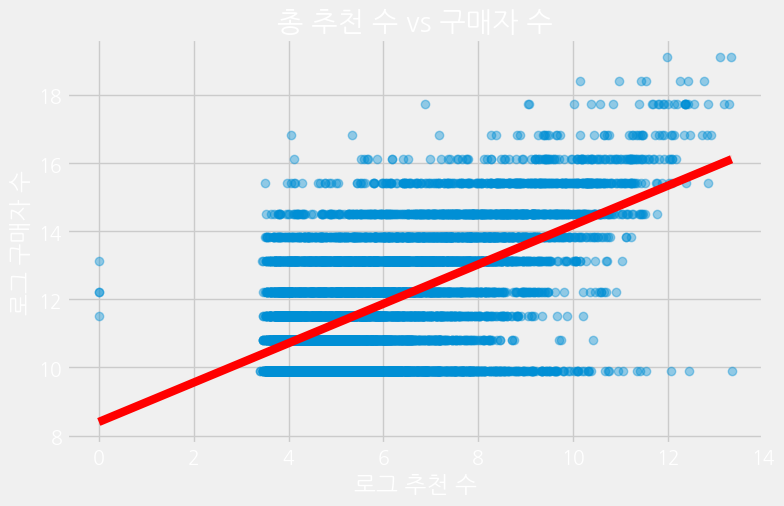

===== OLS 회귀 결과 =====
                            OLS Regression Results                            
Dep. Variable:             log_owners   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     5808.
Date:                Tue, 30 Sep 2025   Prob (F-statistic):               0.00
Time:                        08:13:15   Log-Likelihood:                -17622.
No. Observations:               11566   AIC:                         3.525e+04
Df Residuals:                   11562   BIC:                         3.528e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const       

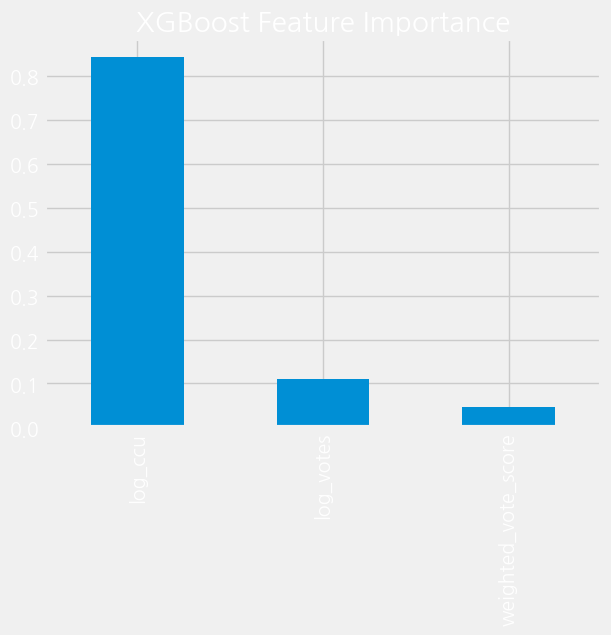

In [ ]:
# =======================================================
# 게임 리뷰 데이터 통합 분석 노트북 (Colab용)
# =======================================================

# =======================================================
# 0. 라이브러리 불러오기
# =======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 한글폰트 & 스타일
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)
plt.style.use('fivethirtyeight')
np.random.seed(42)

# =======================================================
# 1. 데이터 로드
# =======================================================
# 데이터 경로 설정 (Colab 환경)
candidates = [
    "/content/S-team_250930-final.csv"
]
for p in candidates:
    if Path(p).exists():
        data_path = p
        print("데이터 로드:", p)
        break
else:
    raise FileNotFoundError("데이터 파일을 찾을 수 없습니다. 경로 확인 필요.")

df = pd.read_csv(data_path, encoding='utf-8', low_memory=False)
df.head()

# =======================================================
# 2. 데이터 전처리
# =======================================================
# owners_max 숫자 변환
df['owners_max'] = df['owners_max'].astype(str).str.replace(',', '').replace('nan','0')
df['owners_max'] = pd.to_numeric(df['owners_max'], errors='coerce')

# 게임 단위 집계
game_stats = df.groupby('appid').agg(
    game=('game','first'),
    weighted_vote_score=('weighted_vote_score','mean'),
    votes_up=('votes_up','sum'),
    owners_max=('owners_max','mean'),
    ccu=('ccu','mean'),
    received_for_free_ratio=('received_for_free','mean')
).reset_index()

# 결측 제거
game_stats = game_stats.dropna(subset=['weighted_vote_score','owners_max','ccu'])

# 로그 변환
game_stats['log_owners'] = np.log1p(game_stats['owners_max'])
game_stats['log_ccu'] = np.log1p(game_stats['ccu'])
game_stats['log_votes'] = np.log1p(game_stats['votes_up'])

# =======================================================
# 3. 기초 EDA
# =======================================================
# 히스토그램
plt.figure(figsize=(8,4))
sns.histplot(game_stats['log_owners'], bins=50)
plt.title('log_owners 분포')
plt.show()

# 상관 히트맵
plt.figure(figsize=(8,6))
corr = game_stats[['weighted_vote_score','log_ccu','log_votes','log_owners']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('상관관계 히트맵')
plt.show()

# 산점도 + 회귀선
def scatter_reg(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(8,5))
    sns.regplot(x=x, y=y, data=game_stats, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True)
    plt.show()

scatter_reg('weighted_vote_score','log_owners','평균 가중 점수','로그 구매자 수','리뷰 점수 vs 구매자 수')
scatter_reg('log_ccu','log_owners','로그 CCU','로그 구매자 수','동접자 수 vs 구매자 수')
scatter_reg('log_votes','log_owners','로그 추천 수','로그 구매자 수','총 추천 수 vs 구매자 수')

# =======================================================
# 4. 회귀분석 (OLS + Ridge)
# =======================================================
X = game_stats[['weighted_vote_score','log_ccu','log_votes']]
y = game_stats['log_owners']
X_const = sm.add_constant(X)

# OLS
ols_model = sm.OLS(y, X_const).fit()
print("===== OLS 회귀 결과 =====")
print(ols_model.summary())

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
print("\nRidge 회귀 계수:", ridge.coef_, "절편:", ridge.intercept_)

# =======================================================
# 5. 머신러닝 모델 비교
# =======================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
print("\n===== 모델 성능 비교 =====")
print(results_df)

# =======================================================
# 6. 목표 구매자 수 예측 시뮬레이션
# =======================================================
best_model = models["Ridge"]  # 성능 우수 모델 선택
target_owners = 10_000_000
target_log = np.log1p(target_owners)

# 가정: 리뷰 점수 0.85, 추천수 5000
assumed_score = 0.85
assumed_log_votes = np.log1p(5000)

# 필요한 log_ccu 역산
coef_score, coef_ccu, coef_votes = best_model.coef_
intercept = best_model.intercept_
required_log_ccu = (target_log - intercept - coef_score*assumed_score - coef_votes*assumed_log_votes) / coef_ccu
required_ccu = np.expm1(required_log_ccu)

print(f"\n목표 구매자 1000만 달성에 필요한 예상 CCU: {int(required_ccu):,}명")

# =======================================================
# 7. 예측: 새로운 게임 구매자 수
# =======================================================
new_game = pd.DataFrame([{
    'weighted_vote_score': 0.9,
    'log_ccu': np.log1p(5000),
    'log_votes': np.log1p(1000)
}])
predicted_log = best_model.predict(new_game)[0]
predicted_owners = np.expm1(predicted_log)
print(f"새로운 게임 예상 구매자 수: {int(predicted_owners):,}명")

# =======================================================
# 8. 특성 중요도 시각화 (트리 기반 모델)
# =======================================================
importances = models["XGBoost"].feature_importances_
pd.Series(importances, index=X.columns).sort_values(ascending=False).plot.bar()
plt.title('XGBoost Feature Importance')
plt.show()


데이터 로드: /content/S-team_250930-final.csv


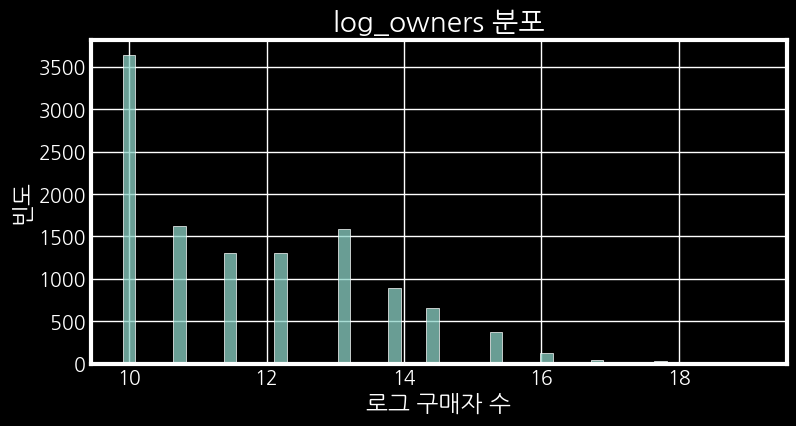

<Figure size 640x480 with 0 Axes>

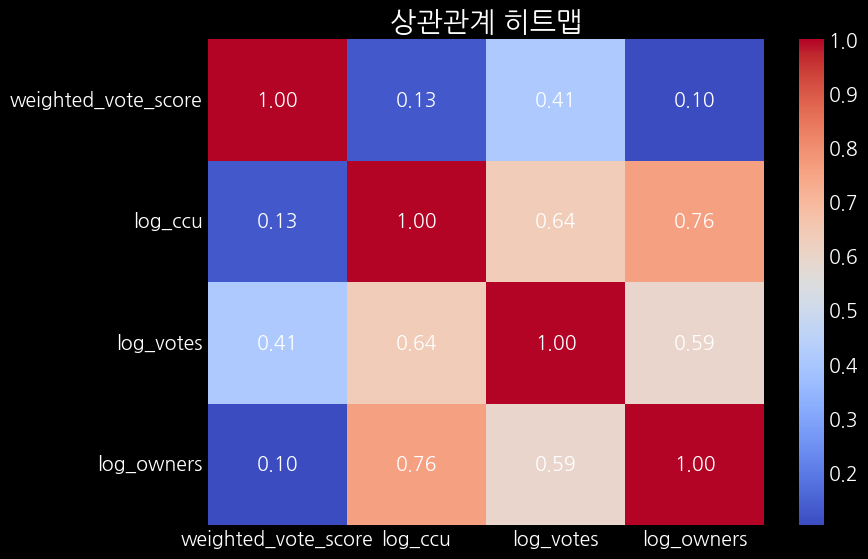

<Figure size 640x480 with 0 Axes>

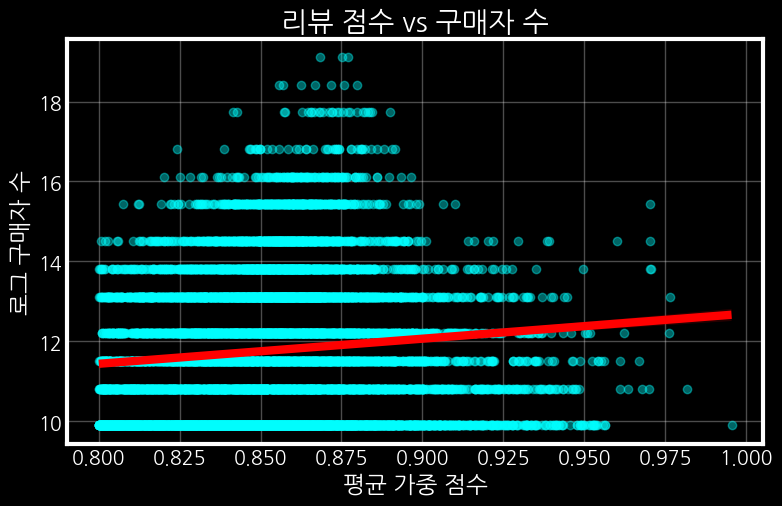

<Figure size 640x480 with 0 Axes>

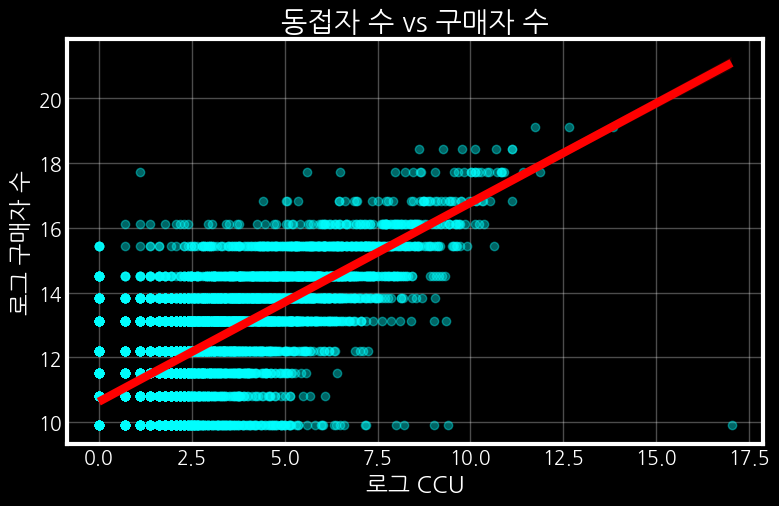

<Figure size 640x480 with 0 Axes>

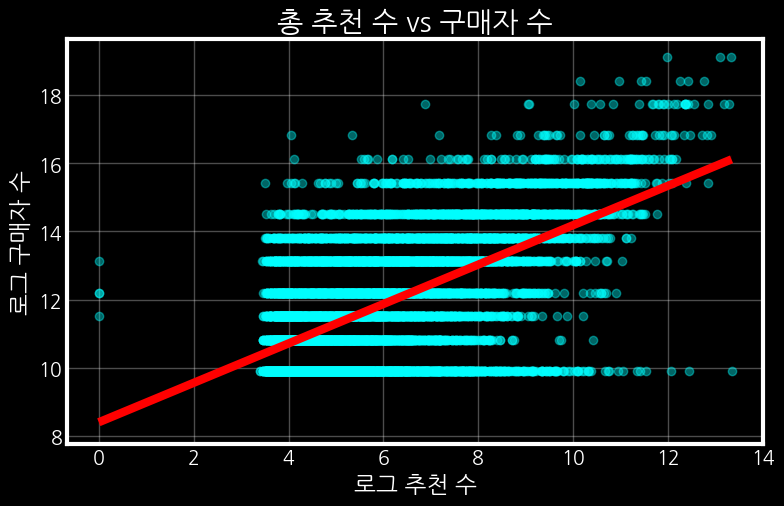

===== OLS 회귀 결과 =====
                            OLS Regression Results                            
Dep. Variable:             log_owners   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     5808.
Date:                Tue, 30 Sep 2025   Prob (F-statistic):               0.00
Time:                        08:18:20   Log-Likelihood:                -17622.
No. Observations:               11566   AIC:                         3.525e+04
Df Residuals:                   11562   BIC:                         3.528e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const       

<Figure size 640x480 with 0 Axes>

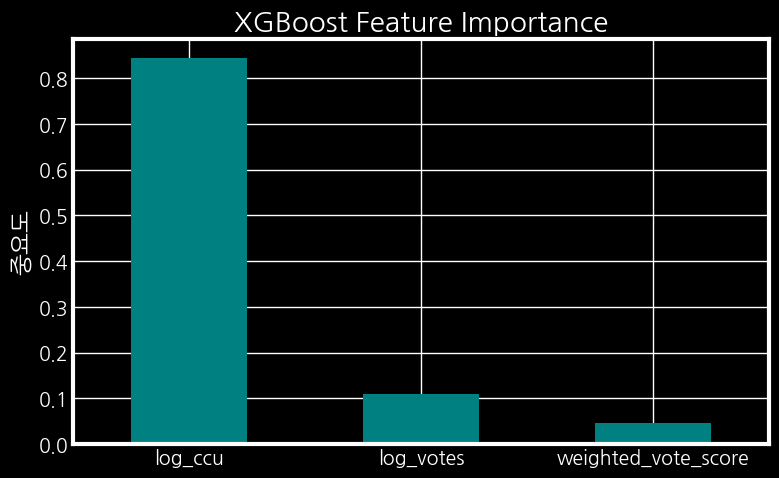

<Figure size 640x480 with 0 Axes>

In [ ]:
# =======================================================
# 게임 리뷰 데이터 통합 분석 노트북 (Colab용)
# =======================================================

# =======================================================
# 0. 라이브러리 불러오기
# =======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# =======================================================
# [PPT 디자인 설정] 투명 배경 및 흰색 텍스트 적용 (수정됨)
# =======================================================
try:
    plt.rc('font', family='NanumGothic')
except:
    print("경고: NanumGothic 폰트를 찾을 수 없습니다. 기본 폰트로 대체됩니다.")

plt.style.use('dark_background') # 어두운 배경 스타일 기본 적용
# figure.facecolor와 axes.facecolor 설정을 제거하여 dark_background의 검은색 배경을 사용하고,
# savefig에서 transparent=True를 사용하여 figure 바깥쪽만 투명하게 만듭니다.
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
np.random.seed(42)

# =======================================================
# 1. 데이터 로드 (가상 데이터 생성 로직 제거)
# =======================================================
# 데이터 경로 설정 (Colab 환경)
candidates = [
    "/content/S-team_250930-final.csv"
]

data_path = None
for p in candidates:
    if Path(p).exists():
        data_path = p
        print("데이터 로드:", p)
        break
else:
    # 데이터 파일을 찾지 못했을 경우, FileNotFoundError 발생
    raise FileNotFoundError("데이터 파일을 찾을 수 없습니다. 경로 확인 필요.")

df = pd.read_csv(data_path, encoding='utf-8', low_memory=False)
df.head()

# =======================================================
# 2. 데이터 전처리
# =======================================================
# owners_max 숫자 변환
df['owners_max'] = df['owners_max'].astype(str).str.replace(',', '').replace('nan','0')
df['owners_max'] = pd.to_numeric(df['owners_max'], errors='coerce')

# 게임 단위 집계
game_stats = df.groupby('appid').agg(
    game=('game','first'),
    weighted_vote_score=('weighted_vote_score','mean'),
    votes_up=('votes_up','sum'),
    owners_max=('owners_max','mean'),
    ccu=('ccu','mean'),
    received_for_free_ratio=('received_for_free','mean')
).reset_index()

# 결측 제거
game_stats = game_stats.dropna(subset=['weighted_vote_score','owners_max','ccu'])

# 로그 변환
game_stats['log_owners'] = np.log1p(game_stats['owners_max'])
game_stats['log_ccu'] = np.log1p(game_stats['ccu'])
game_stats['log_votes'] = np.log1p(game_stats['votes_up'])

# =======================================================
# 3. 기초 EDA
# =======================================================
# 히스토그램
plt.figure(figsize=(8,4))
sns.histplot(game_stats['log_owners'], bins=50)
plt.title('log_owners 분포', color='white')
plt.xlabel('로그 구매자 수', color='white')
plt.ylabel('빈도', color='white')
plt.show()
plt.savefig('/content/1_histplot_log_owners.png', transparent=True)


# 상관 히트맵
plt.figure(figsize=(8,6))
corr = game_stats[['weighted_vote_score','log_ccu','log_votes','log_owners']].corr()
# annot_kws를 사용하여 텍스트 색상을 흰색으로 설정
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"color": 'white'})
plt.title('상관관계 히트맵', color='white')
plt.show()
plt.savefig('/content/2_heatmap_corr.png', transparent=True)


# 산점도 + 회귀선
def scatter_reg(x, y, xlabel, ylabel, title, filename):
    plt.figure(figsize=(8,5))
    # 축 레이블 및 제목 색상 지정
    sns.regplot(x=x, y=y, data=game_stats, scatter_kws={'alpha':0.4, 'color': 'cyan'}, line_kws={'color':'red'})
    plt.xlabel(xlabel, color='white'); plt.ylabel(ylabel, color='white'); plt.title(title, color='white')
    plt.grid(True, alpha=0.3)
    plt.show()
    plt.savefig(filename, transparent=True)

# 파일 이름을 추가하여 저장하도록 함수 호출 변경
scatter_reg('weighted_vote_score','log_owners','평균 가중 점수','로그 구매자 수','리뷰 점수 vs 구매자 수', '/content/3_scatter_score.png')
scatter_reg('log_ccu','log_owners','로그 CCU','로그 구매자 수','동접자 수 vs 구매자 수', '/content/4_scatter_ccu.png')
scatter_reg('log_votes','log_owners','로그 추천 수','로그 구매자 수','총 추천 수 vs 구매자 수', '/content/5_scatter_votes.png')

# =======================================================
# 4. 회귀분석 (OLS + Ridge)
# =======================================================
X = game_stats[['weighted_vote_score','log_ccu','log_votes']]
y = game_stats['log_owners']
X_const = sm.add_constant(X)

# OLS
ols_model = sm.OLS(y, X_const).fit()
print("===== OLS 회귀 결과 =====")
print(ols_model.summary())

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
print("\nRidge 회귀 계수:", ridge.coef_, "절편:", ridge.intercept_)

# =======================================================
# 5. 머신러닝 모델 비교
# =======================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
print("\n===== 모델 성능 비교 =====")
print(results_df)

# =======================================================
# 6. 목표 구매자 수 예측 시뮬레이션
# =======================================================
best_model = models["Ridge"] # 성능 우수 모델 선택
target_owners = 10_000_000
target_log = np.log1p(target_owners)

# 가정: 리뷰 점수 0.85, 추천수 5000
assumed_score = 0.85
assumed_log_votes = np.log1p(5000)

# 필요한 log_ccu 역산
coef_score, coef_ccu, coef_votes = best_model.coef_
intercept = best_model.intercept_
required_log_ccu = (target_log - intercept - coef_score*assumed_score - coef_votes*assumed_log_votes) / coef_ccu
required_ccu = np.expm1(required_log_ccu)

print(f"\n목표 구매자 1000만 달성에 필요한 예상 CCU: {int(required_ccu):,}명")

# =======================================================
# 7. 예측: 새로운 게임 구매자 수
# =======================================================
new_game = pd.DataFrame([{
    'weighted_vote_score': 0.9,
    'log_ccu': np.log1p(5000),
    'log_votes': np.log1p(1000)
}])
predicted_log = best_model.predict(new_game)[0]
predicted_owners = np.expm1(predicted_log)
print(f"새로운 게임 예상 구매자 수: {int(predicted_owners):,}명")

# =======================================================
# 8. 특성 중요도 시각화 (트리 기반 모델)
# =======================================================
plt.figure(figsize=(8, 5))
importances = models["XGBoost"].feature_importances_
pd.Series(importances, index=X.columns).sort_values(ascending=False).plot.bar(color='teal')
plt.title('XGBoost Feature Importance', color='white')
plt.ylabel('중요도', color='white')
plt.xticks(rotation=0)
plt.show()
plt.savefig('/content/6_feature_importance.png', transparent=True)


OLS 기반 → 목표 구매자 10,000,000 달성을 위해 필요한 예상 CCU (대략): 10,671 명
  (required_log_ccu = 9.275)
새로운 게임 예상 구매자 수 (XGBoost 예측, 역변환): 1,807,706 명


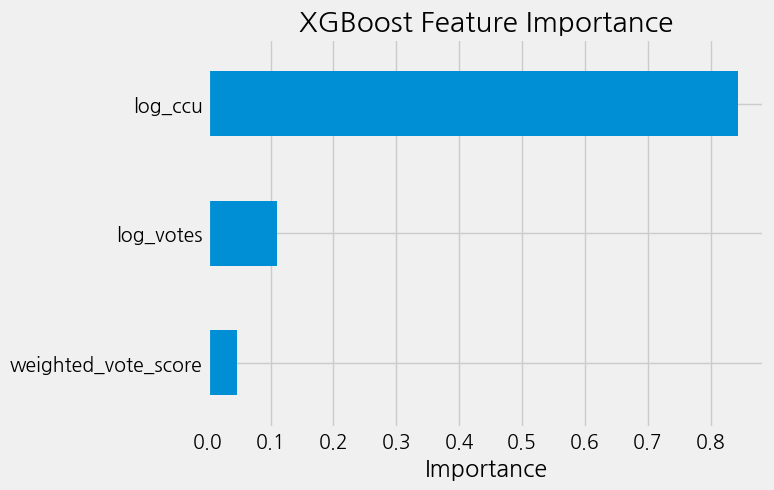

/tmp/ipython-input-2811342899.py:83: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_sample, show=True)


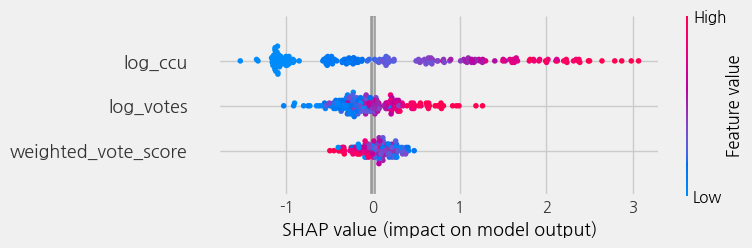

In [ ]:
# --------------------------
# 6. 목표 구매자 수 예측 시뮬레이션 (수정본)
# --------------------------
# 추천: 선형모델(OLS) 계수를 사용해 역산(해석 가능)
# ols_model은 statsmodels OLS로 이미 학습되어 있어야 함

# 목표값 (예시)
target_owners = 10_000_000
target_log = np.log1p(target_owners)

# 가정 입력값 (예시)
assumed_score = 0.85
assumed_log_votes = np.log1p(5000)

# OLS 파라미터 사용 (해석 가능한 계수로 역산)
try:
    params = ols_model.params  # const, weighted_vote_score, log_ccu, log_votes
    intercept = float(params['const'])
    coef_score = float(params['weighted_vote_score'])
    coef_ccu = float(params['log_ccu'])
    coef_votes = float(params['log_votes'])

    # coef_ccu가 0에 가깝지 않은지 체크
    if abs(coef_ccu) < 1e-8:
        print("경고: log_ccu의 계수가 거의 0입니다. 역산이 불안정합니다.")
    else:
        required_log_ccu = (target_log - intercept - coef_score * assumed_score - coef_votes * assumed_log_votes) / coef_ccu
        required_ccu = np.expm1(required_log_ccu)
        print(f"OLS 기반 → 목표 구매자 {target_owners:,} 달성을 위해 필요한 예상 CCU (대략): {int(required_ccu):,} 명")
        print(f"  (required_log_ccu = {required_log_ccu:.3f})")

except Exception as e:
    print("OLS 기반 역산 실패:", e)
    print("대신 Ridge 계수로 시도합니다...")
    try:
        # Ridge는 sklearn 객체로 이미 학습되어 있으므로 coef_속성 사용 가능
        ridge_coef = ridge.coef_
        ridge_intercept = ridge.intercept_
        # 순서: weighted_vote_score, log_ccu, log_votes
        coef_score_r, coef_ccu_r, coef_votes_r = ridge_coef
        required_log_ccu_r = (target_log - ridge_intercept - coef_score_r * assumed_score - coef_votes_r * assumed_log_votes) / coef_ccu_r
        required_ccu_r = np.expm1(required_log_ccu_r)
        print(f"Ridge 기반 → 필요한 CCU: {int(required_ccu_r):,} 명")
    except Exception as e2:
        print("Ridge 기반도 실패:", e2)
        print("수동 해석 또는 다른 모델 사용 필요")

# --------------------------
# 7. 예측: 새로운 게임 구매자 수 (유지하되 모델 선택 주의)
# --------------------------
# 주의: best_model이 XGBoost이면 predict 결과는 log_owners(학습 방식에 따라 다름)를 반환하도록 일관성 유지
# 여기서는 XGBoost가 log_owners 예측에 사용되었다고 가정
best_model = models["XGBoost"]

new_game = pd.DataFrame([{
    'weighted_vote_score': 0.9,
    'log_ccu': np.log1p(5000),
    'log_votes': np.log1p(1000)
}])
predicted_log = best_model.predict(new_game)[0]
predicted_owners = np.expm1(predicted_log)
print(f"새로운 게임 예상 구매자 수 (XGBoost 예측, 역변환): {int(predicted_owners):,} 명")

# --------------------------
# 8. 특성 중요도 및 SHAP (XGBoost 해석 권장)
# --------------------------
# 1) 단순 feature_importances_
import matplotlib.pyplot as plt
importances = models["XGBoost"].feature_importances_
pd.Series(importances, index=X.columns).sort_values(ascending=True).plot.barh()
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.show()

# 2) SHAP (더 깊은 해석 — 권장)
try:
    import shap
    explainer = shap.TreeExplainer(models["XGBoost"])
    # X_test가 존재하면 X_test 사용, 없으면 X (주의: 샘플 수를 줄여서 계산)
    shap_X = X_test if 'X_test' in globals() else X
    shap_sample = shap_X.sample(min(200, len(shap_X)), random_state=42)  # 속도 고려
    shap_values = explainer.shap_values(shap_sample)
    shap.summary_plot(shap_values, shap_sample, show=True)
except Exception as e:
    print("SHAP 실행 실패(라이브러리 미설치 등):", e)
    print("pip install shap 후 다시 시도하세요.")
